# Performance profiles

This notebook shows how to use the `corsort` package to determine the average termination time of several sorting algorithms.

Here the following sorts will be compared:

- Mergesort
- Ford-Johnson $\rho$
- Quicksort
- ASort $\rho$
- Mergesort BFS $\rho$
- Corsort $\rho$

First we load some packages.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from multiprocess.pool import Pool

from corsort import SortFordJohnson, SortMergeBfs, SortMergeDfs, SortAsortQuickselect, SortLargestInterval, SortQuick
from corsort import WrapFullJit, WrapSortScorer, evaluate_convergence
from corsort.jit_scorers import scorer_spaced
from corsort.jit_sorts import jit_corsort_drift_max_spaced
from corsort.presets import auto_colors

We populate the list of sorts we want to study. As we consider profiles, the scorer used matters (here $\rho$ is the main external scorer).

In [2]:
sort_list = [
    SortMergeDfs(compute_history=True),
    WrapSortScorer(scorer=scorer_spaced, sort=SortFordJohnson(), compute_history=True),
    SortQuick(compute_history=True),
    WrapSortScorer(scorer=scorer_spaced, sort=SortAsortQuickselect(), compute_history=True),
    WrapSortScorer(scorer=scorer_spaced, sort=SortMergeBfs(), compute_history=True),
    WrapFullJit(jit_corsort_drift_max_spaced, compute_history=True)]

We decide the value of $n$ to study and the number of trials. For this notebook, we limit to $100$ trials but for better quality 10,000 is recommended (takes a bit more time).

In [3]:
n = 1000
nt = 100

We now run the experiments, with some multi-processing to speed-up things.

In [4]:
with Pool() as p:
    convergence = evaluate_convergence(sort_list=sort_list, n=n, nt=nt, pool=p)

Evaluate convergence of mergesort_dfs for n = 1000


100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


Evaluate convergence of ford_johnson_spaced for n = 1000


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Evaluate convergence of quicksort for n = 1000


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


Evaluate convergence of asort_quickselect_spaced for n = 1000


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Evaluate convergence of mergesort_bfs_spaced for n = 1000


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Evaluate convergence of corsort_drift_max_spaced for n = 1000


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Then we display the results.

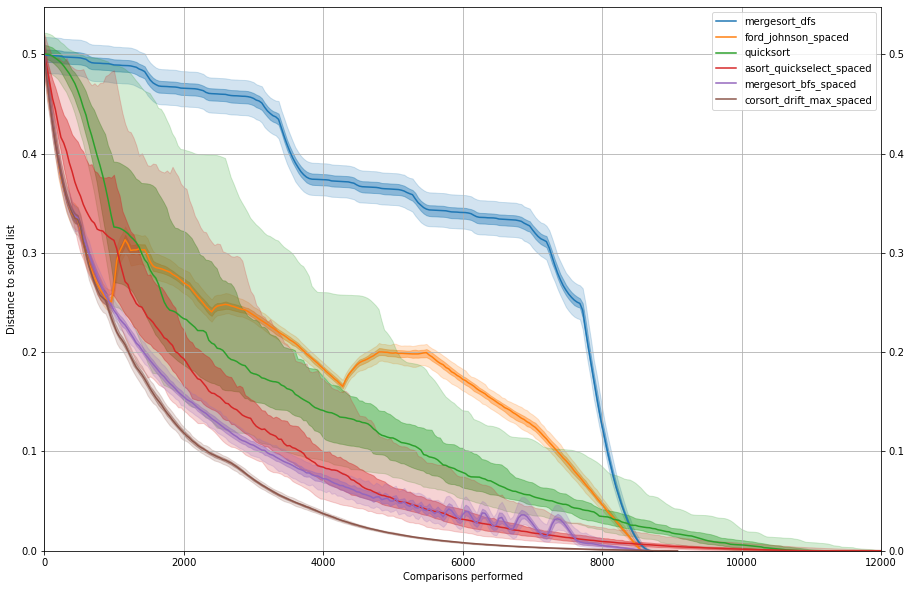

In [5]:
m = n*(n-1)/2
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
decim=40
color_dict = auto_colors(sort_list)
for name, ref in convergence.items():
    color = color_dict[name]
    p_m = ref.shape[1]
    x = np.arange(p_m)[::decim]
    ref = ref[:, ::decim]
    q = np.zeros((5, ref.shape[1]))
    for i, per in enumerate([2.5, 25, 50, 75, 97.5]):
        q[i, :] = np.percentile(ref, per, axis=0)
    q = q/m
    ax.plot(x, q[2, :], label=name, color=color)
    ax.fill_between(x, q[1, :], q[3, :], alpha=.4, color=color)
    ax.fill_between(x, q[0, :], q[4, :], alpha=.2, color=color)
plt.legend()
plt.grid()
ax.tick_params(labelright=True, right=True)
plt.ylabel('Distance to sorted list')
plt.xlabel('Comparisons performed')
plt.ylim([0, None])
plt.xlim([0, 12000])
plt.show()